# Baseline Transformer Model Training Notebook

In this notebook, we created and trained a transformer model based on our decided model architecture framework as our baseline model. The architecture is defined as per the 'base_model.py' file, and we utilise functions created in the 'base_functions.py' file to facilitate the training process. The main aim of this notebook is to perform sanity checks on our model implementation and training loop, as well as to establish a baseline performance for future model improvements to be compared against.

In [1]:
import numpy as np
import jax
import optax
import time
import matplotlib.pyplot as plt

import base_functions as fn

# Loading the Data

The dataset used is the text8 dataset, which has 100M characters of text data from Wikipedia articles. It contains only lowercase letters and spaces, and is already pre-split into 90M characters for training and 10M characters for testing.

In [2]:
# Read in training text file
with open('./data/text8_train.txt', 'r', encoding='utf-8') as f:
    train_text = f.read()
print(f"Training text loaded. Length: {len(train_text) :,} characters.")

# Read in test text file
with open('./data/text8_test.txt', 'r', encoding='utf-8') as f:
    test_text = f.read()
print(f"Test text loaded. Length: {len(test_text) :,} characters.")

Training text loaded. Length: 90,000,000 characters.
Test text loaded. Length: 5,000,000 characters.


In [3]:
# Inspect first 500 characters of training text
print("First 500 characters of training text:")
print(train_text[:500])

First 500 characters of training text:
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


In [4]:
chars = sorted(set(train_text)) # unique characters in training text
chars_to_int = {ch: i for i, ch in enumerate(chars)} # char to int mapping
int_to_chars = {i: ch for i, ch in enumerate(chars)} # int to char mapping
vocab_size = len(chars) # size of vocabulary

print(f"Unique characters in training text: {vocab_size}") # should be 27, including space

Unique characters in training text: 27


We further split the training data into a training set (90% of characters) and a validation set (remaining 10%) to monitor the model's performance during training.

In [5]:
train_text, val_text = fn.split_train_val(train_text, val_fraction=0.1)

print(f"Training text length: {len(train_text) :,} characters.")
print(f"Validation text length: {len(val_text) :,} characters.")

Training text length: 80,999,996 characters.
Validation text length: 9,000,004 characters.


# Model Initialisation

## Model Setup

We intialise our model with the following hyperparameters:
- d_model (token embedding dimension): 256
- n_heads (number of attention heads): 4
- n_layers (number of transformer blocks): 4
- mlp_ratio (MLP hidden layer size ratio): 4
- batch_size (no. of batches per training step): 64
- seq_len (sequence length): 64
- dropout_rate: 0.0
- learning_rate: 1e-3

Based on these parameters, our model has approximately ~3.2M parameters.

In [6]:
# Define the model params
rng = jax.random.PRNGKey(0)

d_model = 256
n_heads = 4
n_layers = 4
mlp_ratio = 4
seq_len = 64
batch_size = 32
dropout_rate = 0.0

m1, params = fn.create_train_state(rng,
        vocab_size = vocab_size,
        d_model = d_model,
        n_heads = n_heads,
        n_layers = n_layers,
        mlp_ratio = mlp_ratio,
        seq_len = seq_len,
        dropout = dropout_rate
)

In [7]:
total_params = fn.count_parameters(params)

print(f"Total number of parameters in the model: {total_params :,}")

Total number of parameters in the model: 3,185,664


We perform a sanity check by running a single forward pass with random input data to ensure the model is functioning as expected.

In [8]:
# SANITY CHECK: Test the model forward pass
B, T = 2, 8  # Batch size and sequence length
batch = jax.random.randint(key = rng, shape = (B, T), minval = 0, maxval = vocab_size)

logits = m1.apply({"params": params}, batch, deterministic=False)
print("Logits shape:", logits.shape)  # Expected: (B, T, vocab)_size)

Logits shape: (2, 8, 27)


## Initialise the optimizer

We use the Adam optimizer with a learning rate of 1e-3 for training our model.

In [9]:
# Define the learning rate
learning_rate = 1e-3

# Create the Optimizer and initialize it
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

print("Optimizer initialized: Adam with Learning Rate =", learning_rate)

Optimizer initialized: Adam with Learning Rate = 0.001


## Text encoding

We then encode the text data into integer format for model training. Each unique character is mapped to a unique integer index.

In [10]:
# Encode the train, val, test texts
train_data = fn.encode(train_text, chars_to_int)
val_data = fn.encode(val_text, chars_to_int)

## Determine maximum permissible training steps

Taking into account possible compute limitations, we perform a preliminary calculation to determine the maximum number of training steps we can perform based on the throughput of our model and the total training time available. For this preliminary test, we set a maximum training time of 60 seconds and a maximum of 1000 training steps.

We set our maximum compute budget for this baseline model to be 1 compute hour. Based on the throughput calculated from the preliminary test, the estimated maximum no. of training steps we can perform within this compute budget is ~155,000. As a benchmark, we set the maximum training steps to be 100,000.

In [11]:
# Determining how many steps we can run in a reasonable time
max_iters = 1000
max_time = 60 # in seconds
max_compute_time = 1 # in hours

_ , max_steps = fn.calculate_throughput(
    max_test_iters = max_iters,
    max_test_time = max_time,
    model = m1,
    params = params,
    opt_state = opt_state,
    optimizer = optimizer,
    rng = rng,
    batch_size = batch_size,
    seq_len = seq_len,
    compute_budget = max_compute_time,
    train_data = train_data
)

Benchmark completed in 23.17 seconds.
Total tokens processed: 2048000
Throughput: 88401.16 tokens/second
Estimated max steps within compute budget: 155392.0


# Model Training & Evaluation

## Training the model

Now, we proceed to train the model over the determined number of training iterations. During training, we monitor the training loss and periodically evaluate the model on the validation set to track its performance. We also make sure to record the time taken for training to ensure it stays within our compute budget.

In [12]:
iter_max = 100000

# To track training and validation loss, as well as time taken
train_loss_history = []
val_loss_history = []
train_time_history = []
val_time_history = []

In [13]:
time_start = time.time()

for it in range(iter_max):

    # get a batch of data
    inputs, targets = fn.get_batch(train_data, batch_size, seq_len)

    # Perform a training step
    rng, sub = jax.random.split(rng)
    new_params, new_opt_state, metrics = fn.train_step(m1, params, opt_state, inputs, targets, optimizer, rng=sub)

    # Update parameters and optimizer state
    params = new_params
    opt_state = new_opt_state
    acc = metrics['acc']
    loss = metrics['loss']
    last_char_acc = metrics['acc_last']

    train_loss_history.append(loss)
    train_time_history.append(time.time() - time_start)

    if it % (iter_max // 50) == 0 or it == iter_max - 1: # Print every 2% of iterations

        # Compute the loss on validation set
        batch_size_val = 1024
        seq_len_val = 32
        val_inputs, val_targets = fn.get_batch(val_data, batch_size_val, seq_len_val)
        val_logits = m1.apply({"params": params}, val_inputs, deterministic=True)
        val_loss, val_metrics = fn.loss_and_metrics(val_logits, val_targets)

        # Record validation loss and time
        val_acc = val_metrics['acc']
        last_char_acc_val = val_metrics['acc_last']
        val_loss_history.append(val_loss)
        time_elapsed = time.time() - time_start
        val_time_history.append(time_elapsed)

        # Print training and validation metrics
        print(f"Iteration {it}, time elapsed: {time_elapsed:.2f} seconds")
        print(f"\t \t Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"\t \t Training Acc: {acc:.4f}, Validation Acc: {val_acc:.4f}")
        print(f"\t \t Last Char Training Acc: {last_char_acc:.4f}, Last Char Validation Acc: {last_char_acc_val:.4f}")
        print("-" * 50)

print(f"Training completed in {time.time() - time_start:.2f} seconds.")

Iteration 0, time elapsed: 3.37 seconds
	 	 Training Loss: 3.5810, Validation Loss: 4.1206
	 	 Training Acc: 0.0522, Validation Acc: 0.1686
	 	 Last Char Training Acc: 0.1250, Last Char Validation Acc: 0.1543
--------------------------------------------------
Iteration 2000, time elapsed: 34.64 seconds
	 	 Training Loss: 1.4868, Validation Loss: 1.5657
	 	 Training Acc: 0.5464, Validation Acc: 0.5177
	 	 Last Char Training Acc: 0.5312, Last Char Validation Acc: 0.5381
--------------------------------------------------
Iteration 4000, time elapsed: 67.12 seconds
	 	 Training Loss: 1.4680, Validation Loss: 1.4932
	 	 Training Acc: 0.5547, Validation Acc: 0.5411
	 	 Last Char Training Acc: 0.5625, Last Char Validation Acc: 0.5518
--------------------------------------------------
Iteration 6000, time elapsed: 99.39 seconds
	 	 Training Loss: 1.4035, Validation Loss: 1.4437
	 	 Training Acc: 0.5625, Validation Acc: 0.5496
	 	 Last Char Training Acc: 0.6250, Last Char Validation Acc: 0.5996

## Plot the training and validation loss curves

After training, we plot the training and validation loss curves to visualize the model's learning progress over time. This helps us identify any potential issues such as overfitting or underfitting. We observe that the training loss decreases steadily, indicating that the model is learning effectively. The validation loss also shows a decreasing trend, suggesting that the model generalizes well to unseen data.

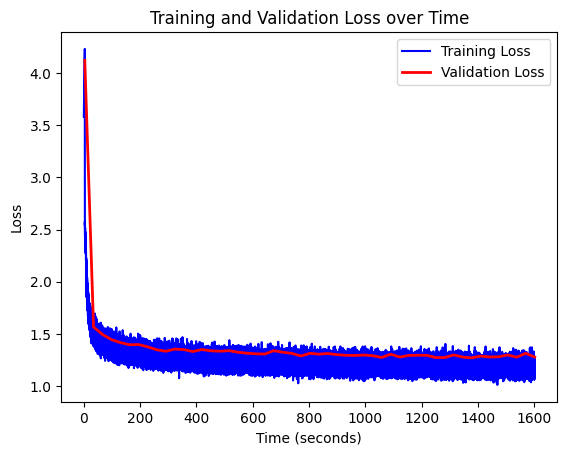

In [14]:
# Plot training and validation loss curves
plt.plot(train_time_history, train_loss_history, "-",label='Training Loss', color='blue')
plt.plot(val_time_history, val_loss_history, "-", label='Validation Loss', lw = 2, color='red')
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss over Time")
plt.legend()
plt.show()

## Testing the model on a given prompt

We finally test the trained model by generating text based on a given prompt. The model successfully generates a sequence of characters that continue from the prompt.

In [15]:
# Test the model on a given prompt
prompt = "the meaning of life is"
encoded_prompt = fn.encode(prompt, chars_to_int)
context = encoded_prompt[None, :]

B = 1
seed = 42
generate_len = 1000
rng = jax.random.PRNGKey(seed)

output_indices = fn.generate_tokens(
    model=m1,
    params=params,
    rng=rng,
    context=context,
    length=generate_len,
    block_size=64,
    temperature=0.8,
    sample=True,
    pad_id=None,
    deterministic=True
)

output_indices = np.array(output_indices)  # Convert from JAX array to NumPy array
generated_text = fn.decode(output_indices, int_to_chars)

print("Generated ID Shape:", output_indices.shape)
print("Generated Text:")
print(prompt + generated_text)

Generated ID Shape: (1, 1000)
Generated Text:
the meaning of life is held by course and general monk man or the member of the inbeing by william and the wife of life however the problems have been trained by the city s plan being simple received by the half of the nobel prophets see also jewish cartoonist behaviour orbitals after a canadian crosby commanded a filter the doctor in december two zero zero four the area derived from those that had to be a religion the problem present in independent one nine eight zero when he was compelling of an enemy award for realism but were prophetic in the appointment on the f four by michael river s two zero zero zero songs about berkeley and the age of one eight seven six and no one had permanent eye from modern exports synodic and the headquartered but as the armada german committee of the royal family which continued to execute the september can be made of individual and a similar plant so the first view was supported did not the third shore of t